<a href="https://colab.research.google.com/github/Priyal2801/DETECTING-CREDIT-CARD-FRAUD/blob/main/Final_Codeforproject_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Importing Libraries </h1>

In [ ]:
import pandas as pd
from skmultiflow.drift_detection.adwin import ADWIN
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import lmfit
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: ignored

<h1> Downloading Data and Creating Dataset</h1>

In [ ]:
Confirmed_detected = pd.read_csv('covid_confirmed.csv')
Recovered_detected = pd.read_csv('covid_recovered.csv')
Deaths_detected = pd.read_csv('covid_death.csv')

In [ ]:
# visualising the data
Confirmed_detected.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,57534,57612,57721,57793,57898,58037,58214,58312,58542,58730
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,129128,129307,129456,129594,129694,129842,129980,130114,130270,130409
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,119142,119323,119486,119642,119805,119992,120174,120363,120562,120736
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,12641,12712,12771,12805,12805,12874,12917,12942,13007,13024
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,23951,24122,24300,24389,24518,24661,24883,25051,25279,25492


In [ ]:
del Confirmed_detected['Province/State']
del Confirmed_detected['Long']
del Confirmed_detected['Lat']

In [ ]:
Confirmed_detected = Confirmed_detected[Confirmed_detected['Country/Region']=='India']

In [ ]:
p = Confirmed_detected.columns

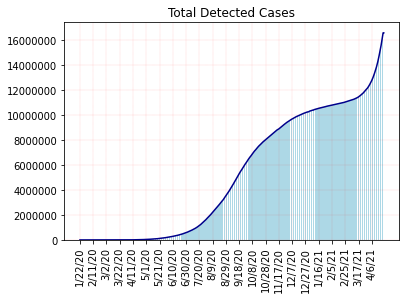

In [ ]:
plt.grid(color = 'red', linestyle = '--', linewidth = 0.1)
plt.bar(p[1:460],Confirmed_detected.iloc[0,1:460],color = 'lightblue')
plt.plot(p[1:460],Confirmed_detected.iloc[0, 1:460], color = 'darkblue')
plt.title('Total Detected Cases')
plt.xticks(np.arange(0,460,20),rotation = 90)
plt.ticklabel_format(style = 'plain', axis = 'y')

In [ ]:
Recovered_detected = Recovered_detected[Recovered_detected['Country/Region']=='India']
Deaths_detected = Deaths_detected[Deaths_detected['Country/Region']=='India']

In [ ]:
del Recovered_detected['Province/State']
del Recovered_detected['Long']
del Recovered_detected['Lat']
del Deaths_detected['Province/State']
del Deaths_detected['Long']
del Deaths_detected['Lat']

In [ ]:
Detected = Confirmed_detected.iloc[0,1:460] - Recovered_detected.iloc[0,1:460] - Deaths_detected.iloc[0,1:460]

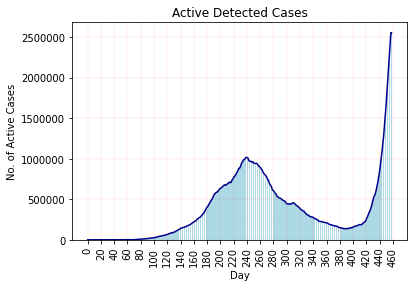

In [ ]:
plt.grid(color = 'red', linestyle = '--', linewidth = 0.1)
plt.bar(range(0,459),Detected,color = 'lightblue')
plt.plot(range(0,459),Detected, color = 'darkblue')
plt.title('Active Detected Cases')
plt.xlabel('Day')
plt.ylabel('No. of Active Cases')
plt.xticks(np.arange(0,480,20),rotation = 90)
plt.ticklabel_format(style = 'plain', axis = 'y')

<h1> Detecting Changes in Detected Cases</h1>

In [ ]:
adwin = ADWIN()
 
previous_variance = 0

for i in range(len(Detected)):
    adwin.add_element(Detected[i])
    if adwin.detected_change():
        print("Change detected in value {}, at index {}".format(Detected[i], i))
        print("Current variance: {}. Previous variance {}".format(adwin.variance, previous_variance))
    previous_variance = adwin.variance

Change detected in value 20486, at index 95
Current variance: 31144027.84546875. Previous variance 24415475.108476453
Change detected in value 89755, at index 127
Current variance: 658170362.0485938. Previous variance 537606943.9431255
Change detected in value 215125, at index 159
Current variance: 3805444688.2064056. Previous variance 3860471442.2412143
Change detected in value 565103, at index 191
Current variance: 19437678128.17266. Previous variance 20261692407.417774
Change detected in value 801282, at index 223
Current variance: 44376543194.03922. Previous variance 56720377833.04715
Change detected in value 937625, at index 255
Current variance: 38931928354.91234. Previous variance 82225607248.34999
Change detected in value 527962, at index 287
Current variance: 23671379141.388874. Previous variance 32452968817.989567
Change detected in value 225449, at index 351
Current variance: 17122041963.806067. Previous variance 60367336444.35109
Change detected in value 143625, at index 38

<h1>Defining Our Model</h1>

In [ ]:
def ivp(y,t,R_0_start, k, x0, R_0_end, N, p_I_to_D, p_D_to_C, p_C_to_R,Beds):
    
    S, E, I, U, D,C, R, Re = y
    
    def logistic_R_0(t, R_0_start, k, x0, R_0_end):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
        
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) / 9
    
    dSdt = -beta(t) * U * S / N
    dEdt = beta(t) * U * S / N - (1/3) * E
    dIdt = (1/3) * E 
    dUdt = (1 - p_I_to_D) * dIdt - (1/9) * U 
    dDdt = p_I_to_D * dIdt - p_D_to_C * (1/12) * D - (1 - p_D_to_C)* (1/9) * D
    dCdt = (1/12) * p_D_to_C * D - (1/6.5) * p_C_to_R * min(Beds, C) - max(0, C-Beds) - (1 - p_C_to_R) * (1/7.5) * min(Beds, C)
    dRdt = (1/9) * (1 - p_D_to_C) * D + (p_C_to_R) * (1/6.5) * min(Beds, C) + (1/9) * U
    dRedt = (1/7.5) * (1 - p_C_to_R) * min(Beds, C) + max(0,C-Beds)
    
    return dSdt, dEdt, dIdt, dUdt,dDdt,dCdt, dRdt, dRedt

In [ ]:
def model (days,R_0_start, k, x0, R_0_end,p_I_to_D, p_D_to_C, p_C_to_R ):
    N = 10000
    Beds = 10 * 0.53
    t = np.linspace(0,days-1,days)
    y0 = N-1, 1, 0,0,0,0,0,0
    sol = odeint(ivp,y0,t,args=(R_0_start, k, x0, R_0_end, N,p_I_to_D, p_D_to_C, p_C_to_R,Beds))
    S, E, I, U, D, C, R, Re = sol.T
    return S, E, I, U, D, C, R, Re

<h1>Fitting our Model</h1>

In [ ]:
#Creating Data
ydata = np.array(Detected[0:383],dtype = int)
xdata = np.linspace(0,382,383,dtype = int)

In [ ]:
params_init_min_max = {"R_0_start": (3.0, 1, 5.0), "k": (2.5, 0.01, 5.0), "x0": (140, 0, 400), "R_0_end": (0.3, 0.1, 1),
                       "pI_to_D": (0.14,0.1, 0.9), "pD_to_C" : (0.10,0.05,0.30), "pC_to_R":(0.80,0.50,1)}

In [ ]:
def fitter(x, R_0_start, k, x0, R_0_end, pI_to_D, pD_to_C, pC_to_R):
    ret = model(383,R_0_start, k, x0, R_0_end, pI_to_D, pD_to_C, pC_to_R)
    return ret[4][x]

In [ ]:
mod = lmfit.Model(fitter)
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [ ]:
result = mod.fit(ydata, params, method="least_squares", x=xdata)

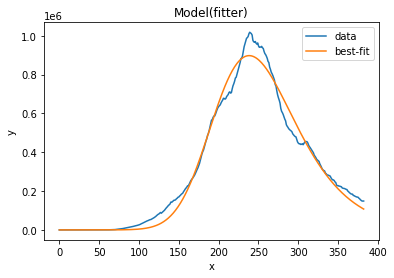

In [ ]:
result.plot_fit(datafmt="-");

In [ ]:
result.best_values

{'R_0_start': 3.774825501949151,
 'k': 0.018349948673473056,
 'x0': 117.55335521641872,
 'R_0_end': 0.9211838252935339,
 'pI_to_D': 0.14786898823707242,
 'pD_to_C': 0.05084162425337291,
 'pC_to_R': 0.6165775973417582}

In [ ]:
1 - result.residual.var() / np.var(ydata)

0.9812982108115544

In [ ]:
1 - result.redchi / np.var(ydata, ddof=2)

0.9803422300726866

In [ ]:
Susceptible,Exposed,Infected,Undetected,detected,Critical,Recovered,Removed = model(383,3.77,0.018,117.553,0.921,0.147,0.051,0.616)

In [ ]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [ ]:
Susceptible[382]

1274040893.3984227

In [ ]:
R0 = logistic_R_0(np.linspace(0,382,383,dtype = int),3.892,0.138,82.779,0.999)

<h3>For Second Wave</h3>

In [ ]:
ydata = np.array(Detected[382:460],dtype = int)
xdata = np.linspace(0,76,77,dtype = int)

In [ ]:
params_init_min_max = {"R_0_start": (3.0, 0.1, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90,0,400), "R_0_end": (0.3, 0.1, 1),
                       "pI_to_D": (0.14,0.01, 0.99), "pD_to_C" : (0.1,0.01,0.99), "pC_to_R":(0.80,0.50,1)}

In [ ]:
def fitter(x, R_0_start, k, x0, R_0_end, pI_to_D, pD_to_C, pC_to_R):
    ret = model(80,R_0_start, k, x0, R_0_end, pI_to_D, pD_to_C, pC_to_R)
    return ret[4][x]

In [ ]:
mod = lmfit.Model(fitter)
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [ ]:
result = mod.fit(ydata, params, method="least_squares", x=xdata)

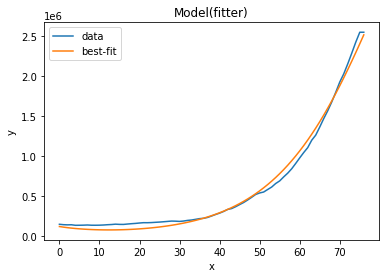

In [ ]:
result.plot_fit(datafmt="-");

In [ ]:
result.best_values

{'R_0_start': 2.1794614049151835,
 'k': 1.1252279260502576,
 'x0': 297.90339648525486,
 'R_0_end': 0.3005379564893568,
 'pI_to_D': 0.024518374427299875,
 'pD_to_C': 0.9899999999939032,
 'pC_to_R': 0.9153398405426052}

In [ ]:
1 - result.residual.var() / np.var(ydata)

0.9923490045725392

In [ ]:
S,E,I,U,D,C,R,Re = model(77,2.179,1.125,297.903,0.301,0.024,0.989,0.915)

In [ ]:
Susceptible = np.concatenate([Susceptible,S])

In [ ]:
Exposed = np.concatenate([Exposed,E])

In [ ]:
Infected = np.concatenate([Infected,I])

In [ ]:
Undetected = np.concatenate([Undetected,U])

In [ ]:
detected = np.concatenate([detected,D])

In [ ]:
Critical = np.concatenate([Critical,C])

In [ ]:
Recovered = np.concatenate([Recovered,R])

In [ ]:
Removed = np.concatenate([Removed,Re])

In [ ]:
t = np.linspace(0,458,459,dtype=int)

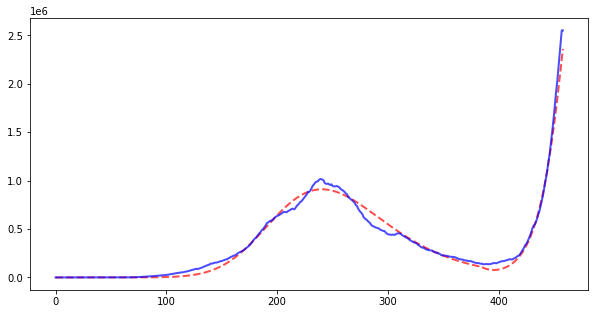

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10,5))
#ax.plot(t, Susceptible, 'brown', alpha=0.7, linewidth=2, label='Susceptible')
#ax.plot(t, Exposed, 'yellow', alpha=0.7, linewidth=2, label='Exposed')
#ax.plot(t, Infected, 'red', alpha=0.7, linewidth=2, label='Infected')
#ax.plot(t, Undetected, 'b--', alpha=0.7, linewidth=2, label='Undetected')
ax.plot(t, detected[0:459], 'r--', alpha=0.7, linewidth=2, label='Detected')
ax.plot(t, Detected, 'blue', alpha=0.7, linewidth=2, label='Critical')
#ax.plot(t, Recovered, 'green', alpha=0.7, linewidth=2, label='Recovered')
#ax.plot(t, Removed, 'black', alpha=0.7, linewidth=2, label='Dead')

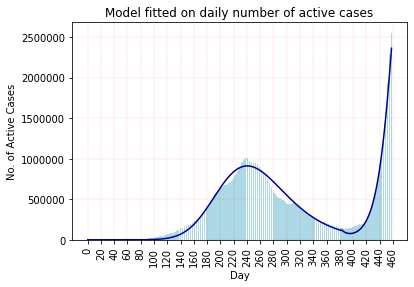

In [ ]:
plt.grid(color = 'red', linestyle = '--', linewidth = 0.1)
plt.bar(range(0,459),Detected,color = 'lightblue')
plt.plot(range(0,459),detected[0:459], color = 'darkblue')
plt.title('Model fitted on daily number of active cases')
plt.xlabel('Day')
plt.ylabel('No. of Active Cases')
plt.xticks(np.arange(0,480,20),rotation = 90)
plt.ticklabel_format(style = 'plain', axis = 'y')

In [ ]:
r0 = logistic_R_0(np.linspace(0,76,77,dtype = int),2.179,1.125,297.90,0.300)

In [ ]:
R0 = np.concatenate([R0,r0])

In [ ]:
len(R0)

460

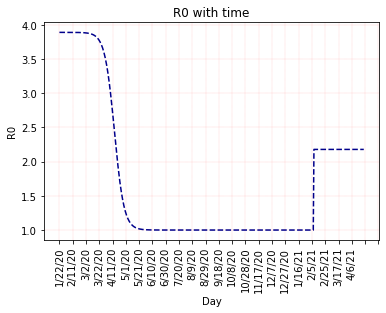

In [ ]:
plt.grid(color = 'red', linestyle = '--', linewidth = 0.1)
plt.plot(p[1:460],R0[0:459],color = 'darkblue', linestyle = '--')
plt.title('R0 with time')
plt.xlabel('Day')
plt.ylabel('R0')
plt.xticks(np.arange(0,500,20),rotation = 90)
plt.ticklabel_format(style = 'plain', axis = 'y')

<h2>Prediction for coming days</h2>

In [ ]:
import numpy as np

In [ ]:
s, e, i, u, d, c, r, re = model(100,3,0.018,20,0.9,0.14,0.05,0.6)

NameError: ignored

In [ ]:
plt.grid(color = 'red', linestyle = '--', linewidth = 0.1)
plt.plot(range(0,100),d,color = 'darkblue', linestyle = '--')
plt.title('Senstivity of d to pI_to_D')
plt.xlabel('Day')
plt.ylabel('d')
plt.xticks(np.arange(0,500,20),rotation = 90)
plt.ticklabel_format(style = 'plain', axis = 'y')